In [2]:
import math 
import numpy as np
import pandas as pd
import sympy
from matplotlib import pyplot as plt
from tabulate import tabulate

In [3]:
def plot_fun(f, a, b, label="", color="r", step=0.01, ax=plt, title="Wykres funkcji"):
    n = int((b-a)/step)+1
    x = np.linspace(a,b,n)[1:]
    ax.plot(x, [f(xi) for xi in x], color=color, label=label)
    if label:
        ax.legend(loc="best")

    if ax is plt:
        ax.title(title)
        ax.xlabel("x")
        ax.ylabel("y")
    else:
        ax.set_title(title)
        ax.set_xlabel("x")
        ax.set_ylabel("y")
    ax.grid()

In [4]:
def abs_diff(F,f, x):
    return [abs(F(xi)-float(f(xi))) for xi in x]

def max_diff(F,f, x):
    return max(abs_diff(F,f, x))

def mean_square_error(F,f, x):
    return sum(d ** 2 for d in abs_diff(F,f, x))

def calculate_error(F, f, a, b, N=1000):
    x = np.linspace(a,b,N)
    diffs = abs_diff(F,f,x)
    return {
        "max": max(diffs),
        "sq": sum(x**2 for x in diffs)
    }

def error(F, f, a, b, N=1000):
    err = calculate_error(F,f,a,b,N)
    print(tabulate([
        ("Bezwzgledny blad", err["max"]),
        ("Suma kwadratów róznic", err["sq"])
    ]))

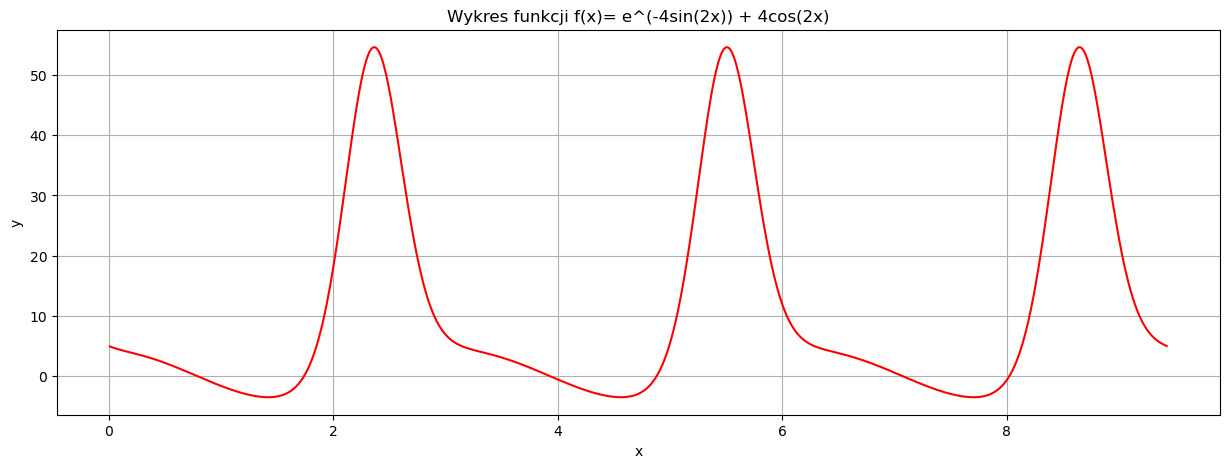

In [5]:
f = lambda x, k, m: math.e**(-k*math.sin(m*x)) + k*math.cos(m*x) 

g = lambda x: f(x, 4, 2)
a = 0
b = 3*math.pi
plt.figure(figsize=(15,5))
plot_fun(g, a, b, title="Wykres funkcji f(x)= e^(-4sin(2x)) + 4cos(2x)") 
plt.show()

In [6]:
def least_square_approximation(x, y, weights, degree):
    X = np.vander(x, degree + 1, increasing=True)
    
    W = np.diag(np.sqrt(weights))
    X_weighted = W @ X
    y_weighted = W @ y
    
    coefficients = np.linalg.lstsq(X_weighted, y_weighted, rcond=None)[0]
    
    y_pred = X @ coefficients
    
    mse = np.mean((y - y_pred) ** 2)
    
    return coefficients, mse

In [29]:
def aproximation_func(x, y, n, deg, w):
    coefficients, mse = least_square_approximation(x, y, w, deg)

    def poly_func(x):
        return sum(coef * x**i for i, coef in enumerate(coefficients))

    return poly_func

def plot_aprox(n, deg, show_err=False):
    x = np.linspace(a,b,n)
    y = [g(xi) for xi in x]
    w = np.ones_like(x)
    F = aproximation_func(x,y,n,deg,w)

    if show_err:
        error(F, g, a,b)

    fig, ax = plt.subplots(1, figsize=(15,4))
    plot_fun(g,a,b,color="blue",ax=ax,label="basis function")
    plot_fun(F,a,b,color="red",ax=ax, label="aproximation", title=f"Aproximation for {n} nodes and {deg} degrees")
    ax.scatter(x,y, color="black")
    plt.show()

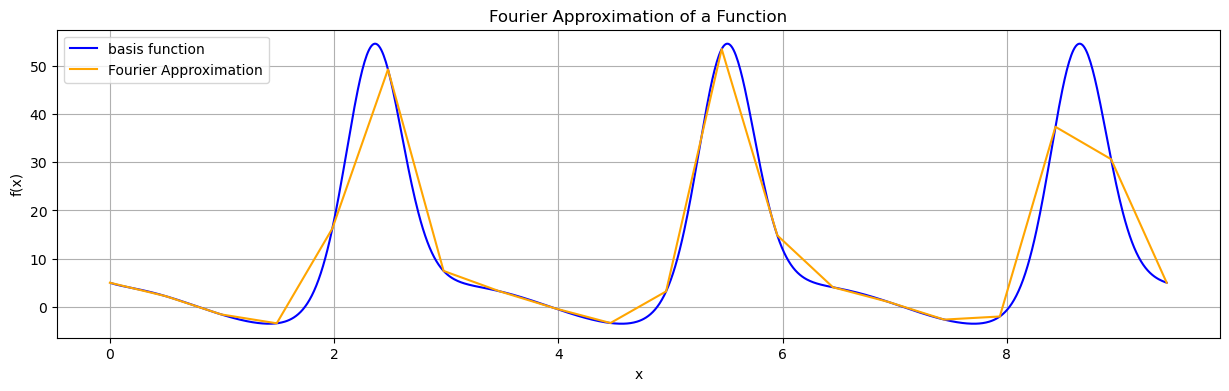

In [31]:
n=20

x = np.linspace(a,b,n)
y = [g(xi) for xi in x]
coefficients = np.fft.fft(y)
approximation = np.fft.ifft(coefficients)

fig, ax = plt.subplots(1, figsize=(15,4))
plot_fun(g, a,b,label="basis function", color="blue")
plt.plot(x, approximation, label='Fourier Approximation', color="orange")
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Fourier Approximation of a Function')
plt.legend()
plt.grid(True)
plt.show()